In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
root = "/content/drive/MyDrive/final/"
# IF not running in colab, commet above and uncomment below
# root = "./"

!pip install transformers sentencepiece

from transformers             import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig,Trainer, TrainingArguments, BertweetTokenizer, BertConfig, RobertaModel,RobertaTokenizer, XLMRobertaTokenizer, XLMRobertaModel
from torch.utils.data         import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics          import f1_score, roc_auc_score, balanced_accuracy_score, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection  import train_test_split
from collections              import Counter
from tqdm                     import tqdm
from torch.nn.utils.rnn       import pad_sequence

import torch.nn.functional as F
import numpy  as np
import pandas as pd

import copy
import torch
import os
import random
import re
import gc
import csv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda')

In [ ]:
test2df1 = pd.read_csv(root + '/ebd/mixed_fake_in_click1.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df1['embedding'] = test2df1['embedding'].apply(converter)

testset1 = TensorDataset(torch.stack(list(test2df1['embedding'])), torch.LongTensor(list(test2df1['label'])))
testloader1 = DataLoader(testset1)
print(len(testloader1))

test2df2 = pd.read_csv(root + '/ebd/mixed_click1.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df2['embedding'] = test2df2['embedding'].apply(converter)

testset2 = TensorDataset(torch.stack(list(test2df2['embedding'])), torch.LongTensor(list(test2df2['label'])))
testloader2 = DataLoader(testset2)
print(len(testloader2))

test2df3 = pd.read_csv(root + '/ebd/mixed_click_in_fake1.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df3['embedding'] = test2df3['embedding'].apply(converter)

testset3 = TensorDataset(torch.stack(list(test2df3['embedding'])), torch.LongTensor(list(test2df3['label'])))
testloader3 = DataLoader(testset3)
print(len(testloader3))

test2df4 = pd.read_csv(root + '/ebd/mixed_fake1.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df4['embedding'] = test2df4['embedding'].apply(converter)

testset4 = TensorDataset(torch.stack(list(test2df4['embedding'])), torch.LongTensor(list(test2df4['label'])))
testloader4 = DataLoader(testset4)
print(len(testloader4))

50
50
50
50


In [ ]:
class Mod(torch.nn.Module):
  def __init__(self, num_hidden, num_outs):
    super().__init__()
    self.fc1 = torch.nn.Linear(768,num_hidden)    
    self.drop = torch.nn.Dropout(0.33)
    self.hidden = torch.nn.Linear(num_hidden,num_outs)

  def forward(self,x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = self.drop(x)
    return self.hidden(x)

model = Mod(num_hidden = 300, num_outs = 2).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5
#model.load_state_dict(torch.load("model_trained_on_fakeddit.pt"))#,state_dict="state_dict")


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/modelFIN", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
x_fic = []
y_fic = []
x_rictr = []
y_rictr = []
x_cic = []
y_cic = []
x_ric = []
y_ric = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader1:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            
            #if target.to(device).cpu()[0].numpy() == 1:
            y = output.to(device).cpu()[0][0][1].numpy()
            x = output.to(device).cpu()[0][0][0].numpy()
            sum_abs = abs(x) + abs(y)
            percent_0 = abs(y) / sum_abs * 100
            percent_1 = abs(x) / sum_abs * 100

            sigmoid_x = 1 / (1 + np.exp(-x))
            sigmoid_y = 1 / (1 + np.exp(-y))

            if target.to(device).cpu()[0].numpy() == 1:
                x_fic.append(sigmoid_y)
                y_fic.append(sigmoid_x)
            else:
                x_rictr.append(sigmoid_y)
                y_rictr.append(sigmoid_x)

            #x_click_pointstr.append(sigmoid_x)
            #y_click_pointstr.append(sigmoid_y)



            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader1)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader2:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            #if target.to(device).cpu()[0].numpy() == 1:
            y = output.to(device).cpu()[0][0][1].numpy()
            x = output.to(device).cpu()[0][0][0].numpy()
            sum_abs = abs(x) + abs(y)
            percent_0 = abs(y) / sum_abs * 100
            percent_1 = abs(x) / sum_abs * 100

            sigmoid_x = 1 / (1 + np.exp(-x))
            sigmoid_y = 1 / (1 + np.exp(-y))
            if target.to(device).cpu()[0].numpy() == 1:
                x_cic.append(sigmoid_y)
                y_cic.append(sigmoid_x)
                
            else:
                x_ric.append(sigmoid_y)
                y_ric.append(sigmoid_x)


            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader2)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.56
F1: 0.5
AUC: 0.5944170771756979
EPOCH: 1 Accuracy:0.9
F1: 0.9180327868852458
AUC: 0.88752052545156


In [ ]:
from torch.nn.functional import normalize
model.load_state_dict(torch.load(root + "model/combined_model.pt", map_location=torch.device('cpu')))
model.eval()

# only to train
#model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load(root + "model/modelFIN2"))\
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
best_f1 = 0
#y_fake_pointstr = []
#x_fake_pointstr = []
x_cif = []
y_cif = []
x_riftr = []
y_riftr = []
x_fif = []
y_fif = []
x_rif = []
y_rif = []
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader3:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            #if target.to(device).cpu()[0].numpy() == 0:
            y = output.to(device).cpu()[0][0][1].numpy()
            x = output.to(device).cpu()[0][0][0].numpy()
            sum_abs = abs(x) + abs(y)
            percent_0 = abs(y) / sum_abs * 100
            percent_1 = abs(x) / sum_abs * 100

            sigmoid_x = 1 / (1 + np.exp(-x))
            sigmoid_y = 1 / (1 + np.exp(-y))

            if target.to(device).cpu()[0].numpy() == 0:
                x_cif.append(sigmoid_x)
                y_cif.append(sigmoid_y)
            else:
                x_rictr.append(sigmoid_x)
                y_rictr.append(sigmoid_y)


            #y_fake_pointstr.append(sigmoid_x)
            #x_fake_pointstr.append(sigmoid_y)


            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader3)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader4:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            #if target.to(device).cpu()[0].numpy() == 0:
            y = output.to(device).cpu()[0][0][1].numpy()
            x = output.to(device).cpu()[0][0][0].numpy()
            sum_abs = abs(x) + abs(y)
            percent_0 = abs(y) / sum_abs * 100
            percent_1 = abs(x) / sum_abs * 100

            sigmoid_x = 1 / (1 + np.exp(-x))
            sigmoid_y = 1 / (1 + np.exp(-y))
            if target.to(device).cpu()[0].numpy() == 0:
                x_fif.append(sigmoid_x)
                y_fif.append(sigmoid_y)
            else:
                x_rif.append(sigmoid_x)
                y_rif.append(sigmoid_y)

            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader4)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.84
F1: 0.8
AUC: 0.8292282430213465
EPOCH: 1 Accuracy:0.82
F1: 0.7804878048780488
AUC: 0.8119868637110016


In [ ]:
import pickle

# Combine data into a single list
data = []

for i in range(len(x_fic)):
    data.append((x_fic[i], y_fic[i], "fakeD_clickM"))

for i in range(len(x_cic)):
    data.append((x_cic[i], y_cic[i], "clickD_clickM"))

for i in range(len(x_ric)):
    data.append((x_ric[i], y_ric[i], "realD_clickM"))

for i in range(len(x_fic)):
    data.append((x_cif[i], y_cif[i], "clickD_fakeM"))

for i in range(len(x_cic)):
    data.append((x_fif[i], y_fif[i], "fakeD_fakeM"))

for i in range(len(x_ric)):
    data.append((x_rif[i], y_rif[i], "realD_fakeM"))

# Dump data to pickle file
with open(root + "points.pickle", "wb") as f:
    pickle.dump(data, f)

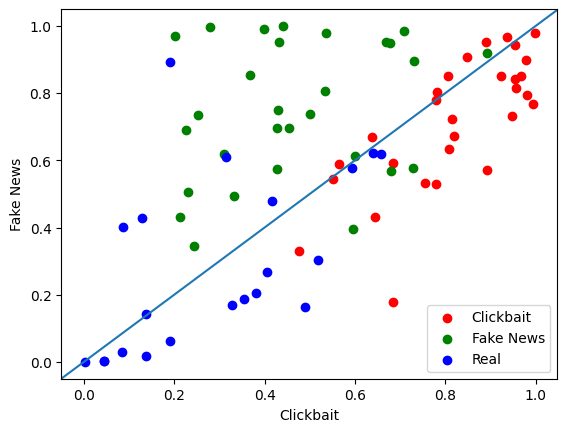

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x_cic, x_cif, c="red", label="Clickbait")
plt.scatter(x_fic, x_fif, c="green", label="Fake News")
plt.scatter(x_ric, x_rif, c="blue", label="Real")
plt.legend()

plt.xlabel("Clickbait")
plt.ylabel("Fake News")
#ax = plt.gca()
#ax.axes.xaxis.set_ticklabels([])
#ax.axes.yaxis.set_ticklabels([])
#plt.axis([a,b,c,d])
plt.axline((0, 0), slope=1)

plt.show()

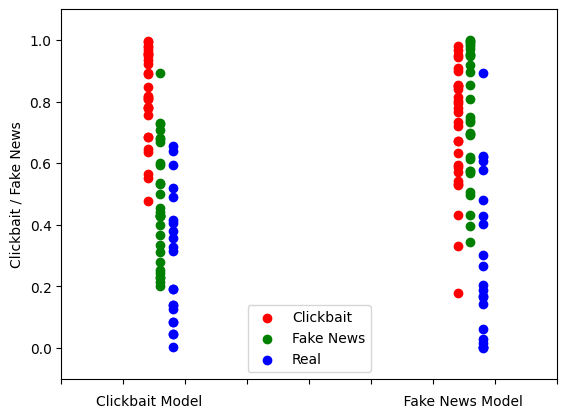

In [ ]:
import matplotlib.pyplot as plt
plt.scatter([[0.35]*len(x_cic)], x_cic, c="red", label="Clickbait")
plt.scatter([[0.40]*len(x_fic)], x_fic, c="green", label="Fake News")
plt.scatter([[0.45]*len(x_ric)], x_ric, c="blue", label="Real")
plt.scatter([[1.60]*len(x_cif)], x_cif, c="red")
plt.scatter([[1.65]*len(x_fif)], x_fif, c="green")
plt.scatter([[1.70]*len(x_rif)], x_rif, c="blue")
plt.legend()

plt.ylabel("Clickbait / Fake News")
plt.xlabel("Clickbait Model                                              Fake News Model")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
#ax.axes.yaxis.set_ticklabels([])
plt.axis([0.0,2.0,-0.1,1.1])
#plt.axline((0, 0), slope=1)

plt.show()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

model.load_state_dict(torch.load(root + "model/modelFIN", map_location=torch.device('cpu')))
model.eval()


hidden_outputs_nptr = []
ytruetr = []
hidden_outputs_np = []
ytrue = []


with torch.no_grad():
    for data, target in testloader1:
        output = model.fc1(data.to(device))
        hidden_outputs_nptr.append(output.cpu().numpy().reshape((1, 300)))
        ytruetr.append(target.numpy())
hidden_outputs_nptr = np.concatenate(hidden_outputs_nptr, axis=0)
ytruetr = np.concatenate(ytruetr, axis=0)

with torch.no_grad():
    for data, target in testloader2:
        output = model.fc1(data.to(device))
        hidden_outputs_np.append(output.cpu().numpy().reshape((1, 300)))
        ytrue.append(target.numpy())

hidden_outputs_np = np.concatenate(hidden_outputs_np, axis=0)
ytrue = np.concatenate(ytrue, axis=0)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
hidden_outputs_2d = tsne.fit_transform(hidden_outputs_np)
hidden_outputs_2dtr = tsne.fit_transform(hidden_outputs_nptr)


model.load_state_dict(torch.load(root + "model/combined_model.pt", map_location=torch.device('cpu')))
model.eval()

hidden_outputs_np1tr = []
ytrue1tr = []

hidden_outputs_np1 = []
ytrue1 = []


with torch.no_grad():
    for data, target in testloader3:
        output = model.fc1(data.to(device))
        hidden_outputs_np1tr.append(output.cpu().numpy().reshape((1, 300)))
        ytrue1tr.append(target.numpy())

hidden_outputs_np1tr = np.concatenate(hidden_outputs_np1tr, axis=0)
ytrue1tr = np.concatenate(ytrue1tr, axis=0)
with torch.no_grad():
    for data, target in testloader4:
        output = model.fc1(data.to(device))
        hidden_outputs_np1.append(output.cpu().numpy().reshape((1, 300)))
        ytrue1.append(target.numpy())

hidden_outputs_np1 = np.concatenate(hidden_outputs_np1, axis=0)
ytrue1 = np.concatenate(ytrue1, axis=0)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
hidden_outputs_2d1 = tsne.fit_transform(hidden_outputs_np1)
hidden_outputs_2d1tr = tsne.fit_transform(hidden_outputs_np1tr)



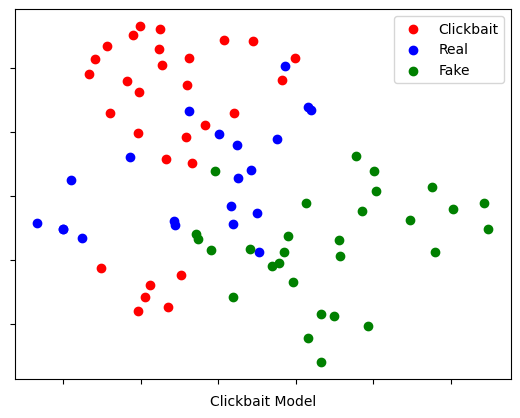

In [ ]:
import matplotlib.pyplot as plt

ytrue_np = ytrue
ytrue_nptr = ytruetr
green_mask = (ytrue_nptr == 1)
red_mask = (ytrue_np == 1)
blue_mask = (ytrue_np == 0)

# Plot points with ytrue=1 in red and ytrue=0 in blue
plt.scatter(hidden_outputs_2d[red_mask, 0], hidden_outputs_2d[red_mask, 1], c='red', label='Clickbait')
plt.scatter(hidden_outputs_2d[blue_mask, 0], hidden_outputs_2d[blue_mask, 1], c='blue', label='Real')
plt.scatter(hidden_outputs_2dtr[green_mask, 0], hidden_outputs_2dtr[green_mask, 1], c='green', label='Fake')
plt.legend()
plt.xlabel("Clickbait Model")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.show()

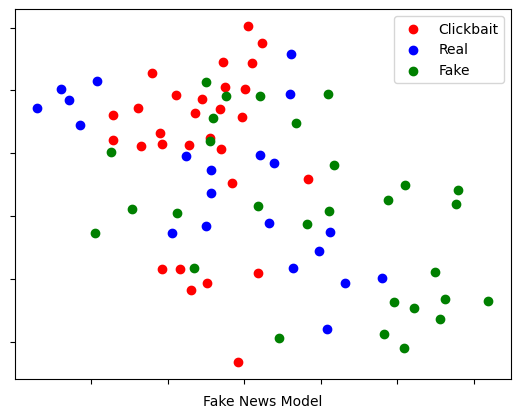

In [ ]:
import matplotlib.pyplot as plt

ytrue_np1 = ytrue1
ytrue_np1tr = ytrue1tr
green_mask = (ytrue_np1tr == 0)
red_mask = (ytrue_np1 == 0)
blue_mask = (ytrue_np1 == 1)

# Plot points with ytrue=1 in red and ytrue=0 in blue
plt.scatter(hidden_outputs_2d1tr[red_mask, 0], hidden_outputs_2d1tr[red_mask, 1], c='red', label='Clickbait')
plt.scatter(hidden_outputs_2d1[blue_mask, 0], hidden_outputs_2d1[blue_mask, 1], c='blue', label='Real')
plt.scatter(hidden_outputs_2d1[green_mask, 0], hidden_outputs_2d1[green_mask, 1], c='green', label='Fake')
plt.legend()
plt.xlabel("Fake News Model")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.show()

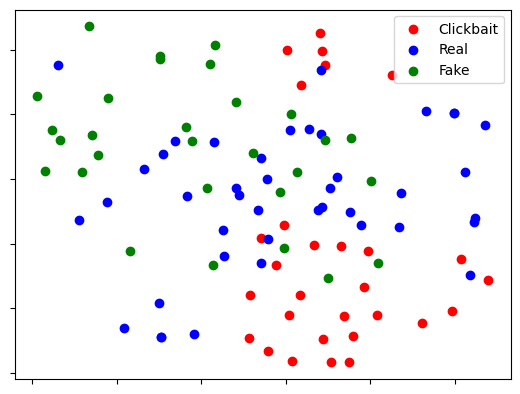

In [ ]:
import matplotlib.pyplot as plt

ytrue_np = ytrue
red_mask = (ytrue_np == 1)
blue_mask = (ytrue_np == 0)

ytrue_np1 = ytrue1
green_mask = (ytrue_np1 == 0)
blue_mask = (ytrue_np1 == 1)



# Plot points with ytrue=1 in red and ytrue=0 in blue
plt.scatter(hidden_outputs_2d[red_mask, 0], hidden_outputs_2d[red_mask, 1], c='red', label='Clickbait')
plt.scatter(hidden_outputs_2d[blue_mask, 0], hidden_outputs_2d[blue_mask, 1], c='blue', label='Real')
plt.scatter(hidden_outputs_2d1[green_mask, 0], hidden_outputs_2d1[green_mask, 1], c='green', label='Fake')
plt.scatter(hidden_outputs_2d1[blue_mask, 0], hidden_outputs_2d1[blue_mask, 1], c='blue')
plt.legend()
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.show()

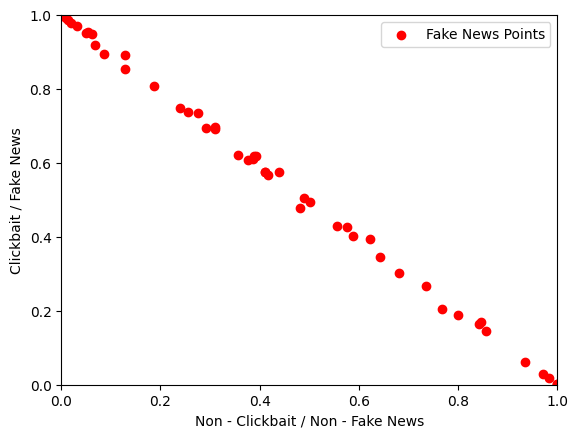

In [ ]:
import matplotlib.pyplot as plt

def rep(x_click_points,y_click_points,x_click_pointstr,y_click_pointstr,x_fake_points,y_fake_points,x_fake_pointstr,y_fake_pointstr,a,b,c,d):
    #plt.scatter(x_click_points, y_click_points, c="green", label="Clickbait Points")
    #plt.scatter(x_click_pointstr, y_click_pointstr, c="orange", label="Tranformed Fake Points")
    plt.scatter(x_fake_points, y_fake_points, c="red", label="Fake News Points")
    #plt.scatter(x_fake_pointstr, y_fake_pointstr, c="lightgreen", label="Transformed Clickbait Points")

    # add a legend to the plot
    plt.legend()

    plt.xlabel("Non - Clickbait / Non - Fake News")
    plt.ylabel("Clickbait / Fake News")
    #ax = plt.gca()
    #ax.axes.xaxis.set_ticklabels([])
    #ax.axes.yaxis.set_ticklabels([])
    plt.axis([a,b,c,d])
    #plt.axline((0, 0), slope=1)

    plt.show()

#rep(x_click_points,y_click_points,x_click_pointstr,y_click_pointstr,x_fake_points,y_fake_points,x_fake_pointstr,y_fake_pointstr,0.0, 0.33, 0.67, 1.0)
#rep(x_click_points,y_click_points,x_click_pointstr,y_click_pointstr,x_fake_points,y_fake_points,x_fake_pointstr,y_fake_pointstr,0.33,0.67,0.33,0.67)
#rep(x_click_points,y_click_points,x_click_pointstr,y_click_pointstr,x_fake_points,y_fake_points,x_fake_pointstr,y_fake_pointstr,0.67,1.0,0.0,0.33)

rep(x_click_points,y_click_points,x_click_pointstr,y_click_pointstr,x_fake_points,y_fake_points,x_fake_pointstr,y_fake_pointstr,0.0,1.0,0.0,1.0)


In [ ]:
import torch.nn as nn
# Load the state dictionaries of the two models
state_dict_fake = torch.load(root + "/model/combined_model.pt")
state_dict_click = torch.load(root + "/model/modelFIN")

In [ ]:
# Merge the state dictionaries of the two models
state_dict_combined = {}
state_dict_combined1 = {}
for key, value in state_dict_fake.items():
    state_dict_combined[key] = value
for key, value in state_dict_click.items():
    state_dict_combined1[key] = value

print(state_dict_combined1['hidden.bias'], state_dict_combined['hidden.bias'])

tensor([-0.0543,  0.0572], device='cuda:0') tensor([ 0.0693, -0.0901], device='cuda:0')


In [ ]:

state_dict_combined['hidden.bias'] = torch.flip(state_dict_combined['hidden.bias'], dims=(0,))

for key in state_dict_combined1:
    state_dict_combined1[key] = (state_dict_combined1[key] + state_dict_combined[key]) / 2

print(state_dict_combined1['hidden.bias'], state_dict_combined['hidden.bias'])

tensor([-0.0722,  0.0633], device='cuda:0') tensor([-0.0901,  0.0693], device='cuda:0')


In [ ]:
# Create a new instance of the model you want to merge the state dictionaries for
merged_model = Mod(num_hidden = 300, num_outs = 2).to(device) 


# Load the merged state dictionary into the merged_model
merged_model.load_state_dict(state_dict_combined1)

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load(root + "model/modelFIN", map_location=torch.device('cpu')))
model.eval()
epochs = 1
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    i = 0
    model.eval()
    with torch.no_grad():
        cnt = 0
        for data, target in testloader:
            cnt += 1                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])

            if output.argmax() == target.to(device):
                successes += 1

            #else:
              #print(cnt, ytrue[cnt - 1], ypred[cnt - 1])


    tmp_f1 = f1_score(ytrue,ypred)
    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(tmp_f1))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

EPOCH: 1 Accuracy:0.8637421852520338
F1: 0.8561764868297531


KeyboardInterrupt: ignored

In [ ]:
%pip install transformers
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from transformers import logging
logging.set_verbosity_error()
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
class Mod(torch.nn.Module):
  def __init__(self, num_hidden, num_outs):
    super().__init__()
    
    self.fc1 = torch.nn.Linear(768,num_hidden)
    
    #self.fc2 = torch.nn.Linear(500,num_hidden)
    self.drop = torch.nn.Dropout(0.33)
    self.hidden = torch.nn.Linear(num_hidden,num_outs)

  def forward(self,x):
   # x = self.pool(x)
    x = torch.nn.functional.relu(self.fc1(x))
    #x = torch.nn.Dropout(0.2)(x)
    x = self.drop(x)
   
    #x = torch.nn.functional.relu(self.fc2(x))
    #x = torch.nn.Dropout(0.2)(x)
    return self.hidden(x)

device = "cuda:0" #might need to change this or add an if cuda.is_available() before it
model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load("model_trained_on_fakeddit.pt"))#,state_dict="state_dict")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss() #I don't think the paper mentioned loss function used
epochs = 10

#Things to tune would be epochs, learning rate for adam, number of hidden layers
#Haven't implemented use of validation set yet
#train2df = pd.read_csv("train10bd.tsv", delimiter="\t")
test2df = pd.read_csv(root + 'mich/test2bd.tsv', delimiter='\t')


from torch import tensor
def converter(x):
    return eval(x)
    

#train2df['embedding'] = train2df['embedding'].apply(converter) #(Takes about 10 min on my pc)




test2df['embedding'] = test2df['embedding'].apply(converter)





#trainset = TensorDataset(torch.stack(list(train2df['embedding'])), torch.LongTensor(list(train2df['label'])))#change depending on 2 3 6 way - 3 and 6 uses _ instead of -
#trainloader = DataLoader(trainset)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))#change depending on 2 3 6 way
testloader = DataLoader(testset)
print(len(testloader))
import os

model.load_state_dict(torch.load(root + "model/combined_model.pt"))
from sklearn import metrics
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    model.train()
    i = 0
    #for data, target in trainloader:
            
           
        #try:
            # optimizer.zero_grad()
            
            # data = data.to(device)
            
            # output = model(data[0].to(device)).to(device)
        
            # loss = criterion(output,target.to(device))
            
            # loss.backward()
            # optimizer.step()
        #except:
           
    
    model.eval()
    with torch.no_grad():
        for i,r in test2df.iterrows():
            
            #try:
                
             
                
                output = model(r["embedding"])
                ypred.append(output.argmax().cpu())
                ytrue.append(r["label"])
            
                
                if output.argmax() == r["label"]:
                    successes += 1
                else:
                    print(r["text"] + "\n label:"+ str(r["label"]) )
                     
            #except:
                
    

    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(metrics.f1_score(ytrue,ypred)))
    print("AUC: " + str(metrics.roc_auc_score(ytrue,ypred)))
    break
    

#Takes around 9 min per epoch on my pc when running the full dataset            



#torch.save(model.state_dict(),"combined_model.pt")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
400
another pardon disgrace
 label:1
five tips for smart people in a not-so-smart world
 label:0
elton john denies trump advisor’s claim that he’s performing at inauguration
 label:1
abusive police technology and dr. turi's predictions
 label:0
goodwill to pay disabled workers in loose change from donated couches
 label:0
bank of canada has a new chief
 label:1
spotted: hillary clinton with bill clinton at a rhode island bookstore - cnnpolitics.com
 label:1
fedex truck splits in half after crash with passenger train
 label:0
boyfriend of pregnant md. teacher indicted in her murder - nbc washington
 label:0
of unicorns and satyrs and things with no knees
 label:1
bach forever! camerata pacifica enters the fray
 label:1
india to revamp its submarine fleet to meet admist rising naval tensions in the region
 label:0
1st skill-based slot machines in us launch in atlantic city
 label:1
armless 